In [2]:
import numpy as np
import pandas as pd
import scipy 
import numpy.matlib
import nilearn
import random
import matplotlib.pyplot as plt
import seaborn as sns
import nilearn
from nilearn import plotting
from nilearn import datasets
import urllib
from sklearn import linear_model 
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib_inline
import matplotlib
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

/Users/elaine/opt/miniconda3/envs/fc_inconsistency/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Organize data

In [3]:
# motor and value areas functional connectivity matrix
motor_value_mat = pd.read_csv('../data//motor_value_fc_matrix_separated_with__.csv', index_col = 'Subject')
# whole-brain functional connectivity matrix 
schaefer_mat = pd.read_csv('../data/schaefer_fc_matrix_separated_with__.csv', index_col = 'Subject')
# inconsistency measures: GARP, Varian, Afriat, Houtman-Maks, MMI
behavioral_results = pd.read_csv('../data/aggregate_indices_subs101_148_08Dec2020.csv', index_col = 'Subject')

In [4]:
X = motor_value_mat
# choose only subjects that did a resting scan
Ys = behavioral_results.loc[motor_value_mat.index]
# shorten names of variables
Ys = Ys.rename({'AFRIAT Index' : 'Afriat Index', 'VARIAN Index AVG(SSQ)' : 'Varian Index', 'MMI Criterion Avg(SumOfSquares(Wastes))' : 'MMI'}, axis = 1)
all_measures = ['GARP Violations', 'Afriat Index', 'Varian Index', 'Houtman Maks Index', 'MMI']
# remove perfectly-consistent subjects
inconsistent_subjects = Ys.loc[:, 'GARP Violations']!=0
Ys_incon = Ys.loc[inconsistent_subjects, :]
X_incon = X.loc[inconsistent_subjects, :]

In [5]:
# Y's correlation matrix
Ys_incon.loc[:, all_measures].corr()

,GARP Violations,Afriat Index,Varian Index,Houtman Maks Index,MMI
GARP Violations,1.000000,0.921882,0.971813,0.884880,0.806522
Afriat Index,0.921882,1.000000,0.981271,0.906334,0.837215
Varian Index,0.971813,0.981271,1.000000,0.912798,0.825225
Houtman Maks Index,0.884880,0.906334,0.912798,1.000000,0.892553
MMI,0.806522,0.837215,0.825225,0.892553,1.000000


## Functions

In [6]:
def select_features(X, y, pval_thresh, number_thresh = 0):
    '''
    Feature selection function. Selects the top features (X) that are most correlated with y, in absolute value.
    Thresholding can be done using correlation's p value or number of top features.
    
    Parameters
    ----------------------------
            X - pandas DataFrame
                feature matrix
            y - numpy float array
                target vairable
            pval_tresh - float
                threshold of correlations' p value to include in the selected features
            number_thresh -  int
                number of features to select
            
    Returns
    ----------------------------
            top_features - string list
                list of the selected features 
    '''
    if number_thresh != 0:
        # select top features using number_thresh
        column_len = len(X.columns)
        # create matrix of repeated Ys in the size of len(X) x len(Y)
        y_mat = np.matlib.repmat(y, column_len, 1)
        # correlate between X and Y save absolute values
        x_y_corr = np.corrcoef(X.transpose(), y_mat)
        abs_corr = np.abs(x_y_corr)
        # sort features and select the top number_thresh features
        top_indices = np.argsort(abs_corr[column_len, 0:column_len])
        top_features = X.columns[top_indices[-1 * number_thresh:]]
    else:
        # select top features using p-value
        top_features = []
        corrs = []
        # calculate the correlation of each feature with y, choose only correlations with p-value < pval_thresh
        for feature in X.columns:
            feature_data = X.loc[:, feature]
            r, pval = correlation_permuation_test(feature_data, y)
            if pval < pval_thresh:
                top_features.append(feature)
                corrs.append(r)
    return top_features

In [7]:
def random_forest_model(X, y, measure, model_type, k_cv=3):
    
    models = []
    scores = []
    y = np.log(y.loc[:, measure])
    n_estimators = np.linspace(60, 250, 10, dtype=int)
    n_estimators = np.insert(n_estimators, 0, 100)
    max_features = ['auto', 'sqrt']
    max_depth = np.linspace(10, 100, 5, dtype=int)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2]
    learning_rate = [1, 2, 3]
    if model_type == 'RandomForest':
        param_grid = {'n_estimators' : n_estimators,
                     'max_features' : max_features,
                     'max_depth' : max_depth,
                     'min_samples_split' : min_samples_split,
                     'min_samples_leaf' : min_samples_leaf}
        model = RandomForestRegressor(n_jobs = -1, random_state = 42)
        # model_cv = RandomizedSearchCV(model, param_distributions = param_grid, n_iter = 4000, 
                                #    cv = 3, n_jobs = -1, random_state = 42)
        model_cv = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, cv=k_cv)
    elif model_type == 'Xgboost':
        model = xgb.XGBRegressor()
        param_grid = {'n_estimators' : n_estimators,
                      'max_depth' : max_depth,
                      'learning_rate' : learning_rate}
        # model_cv = RandomizedSearchCV(model, param_distributions = param_grid, n_iter = 100, 
                            #   cv = k_cv, n_jobs = -1, random_state = 42)  
        model_cv = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, cv=k_cv)

    
    features = X.columns
    features = features.append(pd.Index(['Score']))
    coef_df = pd.DataFrame(features, columns = ['Feature'])

    loo = model_selection.LeaveOneOut()
    i = 1
    y_hats = []
    y_true = []
    coefs_list = []
    for train_ind, test_ind in loo.split(X):
        X_train, X_test = X.iloc[train_ind, :], X.iloc[test_ind, :]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

        # scaling X by subject
        X_train = (X_train.transpose() - np.mean(X_train, axis=1)) / np.std(X_train, axis=1)
        X_train = X_train.transpose()
        # scaling by subject therefore using X_test mean and SD
        X_test = (X_test.transpose() - np.mean(X_test, axis=1)) / np.std(X_test, axis=1)
        X_test = X_test.transpose()
        # scale y_train
        mean_y = np.mean(y_train)
        std_y = np.std(y_train)
        y_train = (y_train - mean_y) / std_y
        # scale y_test with *y_train*
        y_test = (y_test - mean_y) / std_y
        
        model_cv.fit(X_train, y_train)
        best_model = model_cv.best_estimator_
        
        y_pred = best_model.predict(X_test)
        models.append((best_model, X_train))
        score = metrics.mean_squared_error(y_test, y_pred)
        y_hats.append(y_pred[0])
        y_true.append(y_test.values[0])
        
        coefs = pd.DataFrame(best_model.feature_importances_)
        coef_df['Coefficient' + str(i)] = np.append(coefs, score)
        coefs_list = coef_df
      
        i += 1
    return coefs_list, y_hats, y_true, models

In [8]:
def linear_models(X, y, measure, model_type, feature_number, k_cv=3):
    '''
    Trains a model: Linear, LASSO, Ridge, ElasticNet, or Random Forest. 
    Split train/test, selects features and predicts in with a leave-one-out procedure
    
    Parameters
    ----------------------------
            X - pandas DataFrame
                feature matrix
            y - pandas DataFrame
                DataFrame of target vairables
            measure - string
                name of target variable
            model_type - string
                string of model type, either:
                    'Linear' - regular linear regression
                    'Lasso' - LASSO regression
                    'Ridge' - Ridge regression
                    'Elastic' - ElasticNet regression
                    'Random Forest' - Random Forest regression
            feature_number - int
                number of features to select

    Returns
    ----------------------------
            coefs_list - DataFrame list (or single DataFrame for Random Forest model)
                list of DataFrames containing coefficients and MSEs of the models 
            y_hats - float array
                predicted target values
            y_true - float array
                true target values
            models - sklearn regressors list
                list of models used in the leave-one-out procedure
    '''
    
    models = []
    scores = []
    # transform y top log(y)
    y = np.log(y.loc[:, measure])
    
    # initiate models, based on model_type
    if model_type == 'Elastic':
        model = linear_model.ElasticNetCV(l1_ratio = np.arange(0.01, 1, 0.02), cv = k_cv, alphas = np.arange(0.01, 1, 0.01), max_iter=50000, n_jobs = -1)
    elif model_type == 'Ridge': 
        model = linear_model.RidgeCV(alphas = np.arange(0.01, 5, 0.01), cv = k_cv)
    elif model_type == 'Lasso': 
        model = linear_model.LassoCV(alphas = np.arange(0.01, 5, 0.01), cv = k_cv, max_iter = 50000, n_jobs = -1)
    elif model_type == 'Linear':
        model = linear_model.LinearRegression(n_jobs = -1)

    loo = model_selection.LeaveOneOut()
    i = 1
    y_hats = []
    y_true = []
    coefs_list = []
    for train_ind, test_ind in loo.split(X):
        X_train, X_test = X.iloc[train_ind, :], X.iloc[test_ind, :]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
        # select top N features with highest correlation with y_train
        selected_features = select_features(X_train, y_train, 0.05, feature_number)
        X_train, X_test = X_train.loc[:, selected_features], X_test.loc[:, selected_features]

        # scaling X by subject
        X_train = (X_train.transpose() - np.mean(X_train, axis=1)) / np.std(X_train, axis=1)
        X_train = X_train.transpose()
        # scaling by subject therefore using X_test mean and SD
        X_test = (X_test.transpose() - np.mean(X_test, axis=1)) / np.std(X_test, axis=1)
        X_test = X_test.transpose()
        # scale y_train
        mean_y = np.mean(y_train)
        std_y = np.std(y_train)
        y_train = (y_train - mean_y) / std_y
        # scale y_test with *y_train*
        y_test = (y_test - mean_y) / std_y
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        # save the models, scores and predicted values
        models.append(model)
        score = metrics.mean_squared_error(y_test, y_pred)
        y_hats.append(y_pred[0])
        y_true.append(y_test.values[0])
        
        # save model's coefficients in DataFrame

        features = X_train.columns
        features = features.append(pd.Index(['Score']))
        coef_df = pd.DataFrame(features, columns = ['Feature'])
        coefs = model.coef_
        coef_df['Coefficient'] = np.append(coefs, score)
        # each model might have different sets of features, so we append all DataFrames to a list 
        coefs_list.append(coef_df)
        i += 1
    return coefs_list, y_hats, y_true, models

In [9]:
def correlation_permuation_test(y_pred, y_true):
    '''
    Test correlation between predicted and true target values using a permuation test
    
    Parameters
    ----------------------------
            y_pred - float array
                predicted target values
            y_true - float array
                true target values
        
    Returns
    ----------------------------
        r - float
            correlation between true and predicted target values
        pval - float
            p-value of the correlation, calculated using a permutation test
    '''
    permutations = 100000
    r, _ = scipy.stats.pearsonr(y_pred, y_true)
    y_pred_permute = y_pred.copy()
    corr_distribution = []

    for i in range(permutations):
        # for each permuation shuffle the predicted values between subjects, and calculate correlation with the true values 
        random.shuffle(y_pred_permute)
        this_corr, _ = scipy.stats.pearsonr(y_pred_permute, y_true)
        corr_distribution.append(this_corr)
        
    pval = sum(r <= corr_distribution) / len(corr_distribution)
    return r, pval, corr_distribution

In [10]:
def average_coefs(coef_df_list):
    '''
    Returns average coefficients of the prediction models.
    
    Parameters
    ----------------------------
            coefs_list - DataFrame list (or single DataFrame for Random Forest model)
                list of DataFrames containing coefficients and MSEs of the models 
    
    Returns
    ----------------------------
            avg_coefs - DataFrame
                DataFrame of average coefficient of all models
            score - float
                average score of models' predictions
    '''
    # if coef_df_list is a list, it contains coefficients of linear models
    if type(coef_df_list) == list:
        number_of_models = len(coef_df_list)
        avg_coefs = pd.DataFrame()
        for i in range(number_of_models):
            coef_df = coef_df_list[i]
            coef_df = coef_df.loc[coef_df.Coefficient != 0]
            coef_df = coef_df.reset_index(drop = True)
            for feature_i in range(len(coef_df)):
                feature = coef_df.Feature[feature_i]
                # if the feature was already in previous models, sum the cofficients
                if feature in avg_coefs.axes[0]:
                    avg_coefs.loc[feature, 'Beta'] = avg_coefs.loc[feature, 'Beta'] + coef_df.iloc[feature_i, 1]
                    avg_coefs.loc[feature, 'Count'] = avg_coefs.loc[feature, 'Count'] + 1
                # else, create a new feature in the dataframe
                else:
                    avg_coefs.loc[feature, 'Beta'] = coef_df.iloc[feature_i, 1]
                    avg_coefs.loc[feature, 'Count'] = 1
        # sort features by count, as features that appear in more models are more important
        avg_coefs = avg_coefs.sort_values(by = 'Count')
        avg_coefs = avg_coefs.reset_index()
        avg_coefs.columns = ['Feature', 'Beta', 'Count']
        # average betas
        avg_coefs.Beta = avg_coefs.Beta / number_of_models
        # find the score and exclude it from avg_coefs
        score_index = avg_coefs.index[avg_coefs.Feature == 'Score'].to_list()[0]
        score = avg_coefs.iloc[score_index, 1]
        avg_coefs = avg_coefs.drop(index = score_index)
    # if coef_df_list isn't a list, it contains feature importance measures of Random Forest models
    else:
        # find the score and exclude it from avg_coefs
        score_index = coef_df_list.index[coef_df_list.Feature == 'Score'].to_list()[0]
        score = np.mean(coef_df_list.iloc[score_index, 1:].to_list())
        coef_df_list = coef_df_list.drop(index = score_index)
        # average feature importance
        agg_importance = np.mean(coef_df_list, axis = 1)
        sort_i = agg_importance.argsort()
        features = coef_df_list.Feature.values
        importance_df = pd.DataFrame([features[sort_i], agg_importance[sort_i]]).transpose()
        importance_df.columns = ['Feature', 'Beta']
        avg_coefs = importance_df.sort_values(by = 'Beta', ascending=False)
        
    return avg_coefs, score

In [11]:
def threshold_p(feature_list, p):
    '''
    '''
    absolute_feautres = np.abs(feature_list)
    absolute_feautres.sort()
    absolute_feautres = absolute_feautres[::-1]
    threshold_index = int(len(feature_list) * p)
    threshold = absolute_feautres[n - 1]
    return threshold

In [12]:
def threshold_n(feature_list, n):
    absolute_feautres = np.abs(feature_list)
    absolute_feautres.sort()
    absolute_feautres = absolute_feautres[::-1]
    threshold = absolute_feautres[n - 1]
    return threshold

In [13]:
def draw_glassbrain(importance_df):
    '''
    Draw glass-brain including the top 5 connetivity features based on importance_df.
    
    Parameters
    ----------------------------
            importance_df - DataFrame
                DataFrame containing coefficients or feature importance of features of a model
    
    '''
    # initiate atlas and labels
    with open("../data/Schaefer2018_100Parcels_7Networks_order_info.txt", 'r') as f:
        parcels_text = f.read()
    # select only even rows, which contain the labels 
    lines = parcels_text.split('\n')[:-1]
    lines = lines[::2]
    # remove prefix from label: "7Networks_"
    parcel_list = [parcel[10:] for parcel in lines]

    schaefer = nilearn.datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7).maps
    coordinates = plotting.find_parcellation_cut_coords(labels_img=schaefer)

    for i in range(len(importance_df)):
        # extract each node's name (splitted by "__")
        node1_name = importance_df.loc[i, 'Feature'].split('__')[0]
        node2_name = importance_df.loc[i, 'Feature'].split('__')[1] 
        importance_df.loc[i, 'Node1'] = int(parcel_list.index(node1_name))
        importance_df.loc[i, 'Node2'] = int(parcel_list.index(node2_name))

    # create features matrix
    node_number = 100
    features_matrix = np.zeros([node_number, node_number])
    for i in range(len(importance_df)):
        row, col = int(importance_df.loc[i, 'Node1']), int(importance_df.loc[i, 'Node2'])
        features_matrix[row, col] = importance_df.loc[i, 'Beta']
        # symmetric matrix, so [row, col] == [col, row]
        features_matrix[col, row] = importance_df.loc[i, 'Beta']
    
    # draw brain
    colors_list = ['purple', 'blue', 'green', 'violet', 'wheat', 'orange', 'red']
    net_names = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
    color_dict = dict(zip(net_names, colors_list))
    node_colors = []
    for name in parcel_list:
        net = name.split('_')[1]
        node_colors.append(color_dict[net])
    # find top 5 features 
    thresh = threshold_n(importance_df.Beta.to_list(), 5)
    _ = plotting.plot_connectome(features_matrix, coordinates, edge_threshold = thresh,
                                 display_mode = 'lzry', node_size = 25, node_color = node_colors, colorbar = True)

In [14]:
def print_results_org(y_true, y_pred, measure, model, plot_dist=0):
    '''
    Plots results of the prediction models in a scatter plot with regression line and its p-value
    
    Parameters
    ----------------------------
            y_pred - float array
                predicted target values
            y_true - float array
                true target values
            measure - string
                name of target variable
            model - string
                name of model for figure title (Linear Regression / Random Forest)
                
    Returns
    ----------------------------
            r - float
                correlation between true and predicted target values
            pval - float
                p-value of the correlation, calculated using a permutation test
    '''
    r, pval, corr_distribution = correlation_permuation_test(y_pred, y_true)
    
    # plot correlation between predicted and true
#     fig = plt.figure(figsize = (8, 5))
#     ax = fig.add_subplot()
    fig, ax = plt.subplots(figsize = (6, 6))
#     df = pd.DataFrame(np.array([sch_y_true, sch_y_hats]).transpose(), columns=['True', 'Predicted'])
#     sns.lmplot(x = 'True', y = 'Predicted', data = df)
    plt.scatter(y_true, y_pred)
    plt.title(model + ' Model', color='#303030', weight='bold')
    plt.xlabel('True ' + measure + ' (Normalized)', color='#303030')
    plt.ylabel('Predicted ' + measure, color='#303030')
    plt.ylim(bottom = -1.3, top = 1.3)
    plt.xlim(left = -2.5, right = 2.5)
    plt.text(0.65, 0.03, 'r = {:.4f}'.format(r) + '\np-val = {:.4f}'.format(pval), transform = ax.transAxes, fontsize = 14, color='#303030')
#     plt.text(0.25, 0.03, 'r = {:.4f}'.format(r) + '\np-val = {:.4f}'.format(pval), transform = ax.transAxes, fontsize = 14)
    font = {'family' : 'sans-serif',
            'weight' : 'regular',
            'size'   : 16}
    plt.rc('font', **font)
    slope, intercept = np.polyfit(y_true, y_pred, 1)
    _ = plt.plot(y_true, np.multiply(y_true, slope) + intercept)
    plt.grid(b=False, axis='both')
    plt.setp(ax.spines.values(), color='#303030')

    if plot_dist:
        # plot correlation distribution
        plt.figure(figsize = (8, 5))
        plt.hist(corr_distribution, bins = 50)
        baseline_r = np.mean(corr_distribution)
        plt.title('Correlation Distribution')
        avg_line = plt.vlines(x = baseline_r, ymin = 0, ymax = 600, colors = 'orange', linestyles = '--')
        real_line = plt.vlines(x = r, ymin = 0, ymax = 600, colors = 'red', linestyles = '--')
        plt.legend([avg_line, real_line], ['Average Correlation', f"Model's Correlation"], fontsize = 12, loc = 'upper left')
        plt.xlabel('Permuted Pearson Correlation Value')
        plt.ylabel('Frequency')
    
    return r, pval

In [15]:
def print_results(y_true, y_pred, measure, model, plot_dist=0):
    '''
    Plots results of the prediction models in a scatter plot with regression line and its p-value
    
    Parameters
    ----------------------------
            y_pred - float array
                predicted target values
            y_true - float array
                true target values
            measure - string
                name of target variable
            model - string
                name of model for figure title (Linear Regression / Random Forest)
                
    Returns
    ----------------------------
            r - float
                correlation between true and predicted target values
            pval - float
                p-value of the correlation, calculated using a permutation test
    '''
    r, pval, corr_distribution = correlation_permuation_test(y_pred, y_true)
    
    # plot correlation between predicted and true
    grey = '#606060'
    scatter_col = '#3377B4'
    line_col = '#338FB4'
    title_col = '#303030'

    matplotlib.rcParams['font.sans-serif'] = "Helvetica"
    matplotlib.rcParams['font.family'] = "sans-serif"

    fig, ax = plt.subplots(figsize = (6, 4))
    plt.scatter(y_true, y_pred, alpha=0.7, color=scatter_col)
    plt.title(model + ' Model', color=title_col, weight='bold', fontsize=16)
    plt.xlabel('True ' + measure + ' (Normalized)', color=grey, fontsize=14)
    plt.ylabel('Predicted ' + measure, color=grey, fontsize=14)
    plt.ylim(bottom = -1.3, top = 1.3)
    plt.xlim(left = -2.5, right = 2.2)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(axis='both', direction='out', color = grey, labelcolor = grey, labelsize=12)
    plt.text(0.80, 0.03, 'r = {:.4f}'.format(r) + '\np = {:.4f}'.format(pval), transform = ax.transAxes, fontsize=13, color=title_col, fontname='Helvetica', weight='bold')

    slope, intercept = np.polyfit(y_true, y_pred, 1)
    _ = plt.plot(y_true, np.multiply(y_true, slope) + intercept, color = scatter_col)
    plt.grid(visible=False, axis='both')
    plt.setp(ax.spines.values(), color=grey)
    if plot_dist:
        # plot correlation distribution
        plt.figure(figsize = (8, 5))
        plt.hist(corr_distribution, bins = 50)
        baseline_r = np.mean(corr_distribution)
        plt.title('Correlation Distribution')
        avg_line = plt.vlines(x = baseline_r, ymin = 0, ymax = 600, colors = 'orange', linestyles = '--')
        real_line = plt.vlines(x = r, ymin = 0, ymax = 600, colors = 'red', linestyles = '--')
        plt.legend([avg_line, real_line], ['Average Correlation', f"Model's Correlation"], fontsize = 12, loc = 'upper left')
        plt.xlabel('Permuted Pearson Correlation Value')
        plt.ylabel('Frequency')
    
    return r, pval

#### Choose inconsistency index

In [16]:
inconsistency_measure = 'Afriat Index'

## Motor-Value Matrix

MSE: 1.092


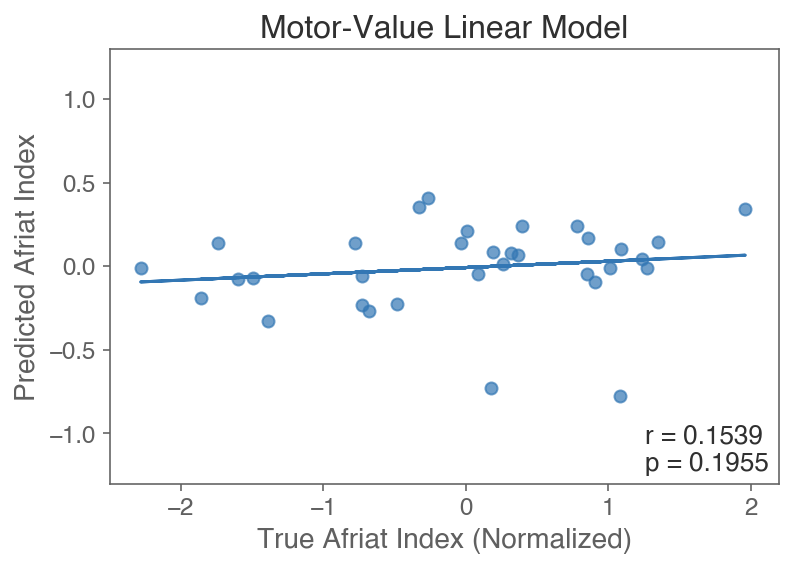

In [25]:
# Motor-value linear regression
coef_df_value_motor, mv_y_hats, mv_y_true, models = linear_models(motor_value_mat.loc[inconsistent_subjects, :], Ys_incon, inconsistency_measure, 'Lasso', 45)
r, pval = print_results(mv_y_true, mv_y_hats, inconsistency_measure, 'Motor-Value Linear')
motor_linear_avg, motor_linear_score = average_coefs(coef_df_value_motor)
print(f'MSE: {motor_linear_score:.3f}')
# motor_linear_avg[-5:]

MSE: 1.094


/Users/elaine/opt/miniconda3/envs/fc_inconsistency/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


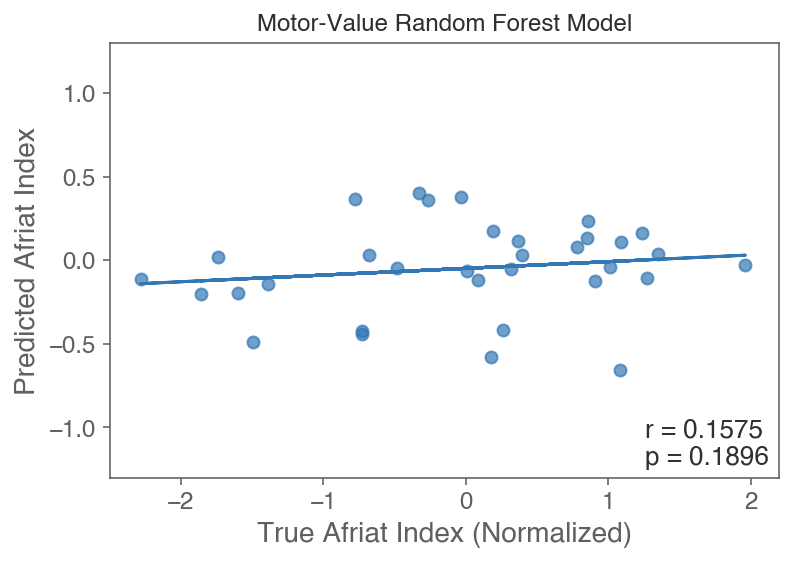

In [28]:
# Motor-value Random Forest
coef_df_value_motor, mv_y_hats, mv_y_true, models = random_forest_model(motor_value_mat.loc[inconsistent_subjects, :], Ys_incon, inconsistency_measure, 'RandomForest', k_cv=3)
r, pval = print_results(mv_y_true, mv_y_hats, inconsistency_measure, 'Motor-Value Random Forest')
plt.title('Motor-Value Random Forest Model')
motor_avg_forest, motor_forest_score = average_coefs(coef_df_value_motor)
print(f'MSE: {motor_forest_score:.3f}')
# motor_avg_forest[-5:]

## Whole-brain Matrix

MSE: 1.067


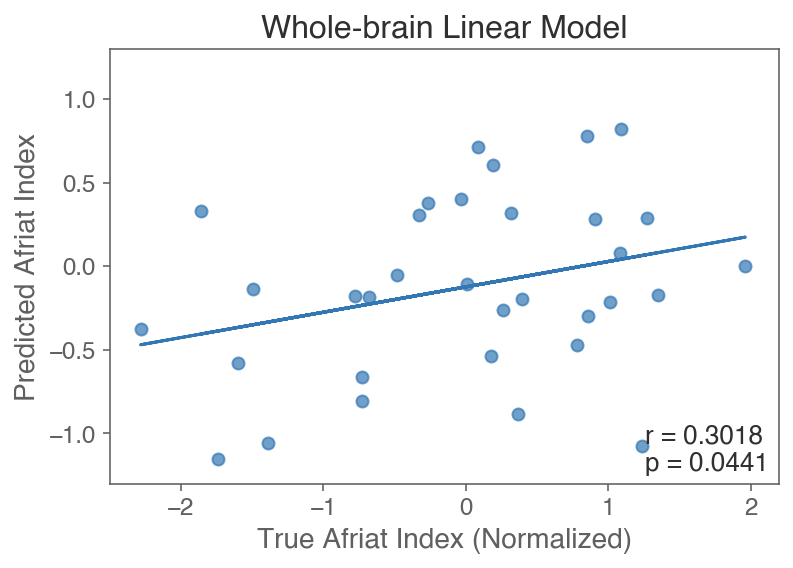

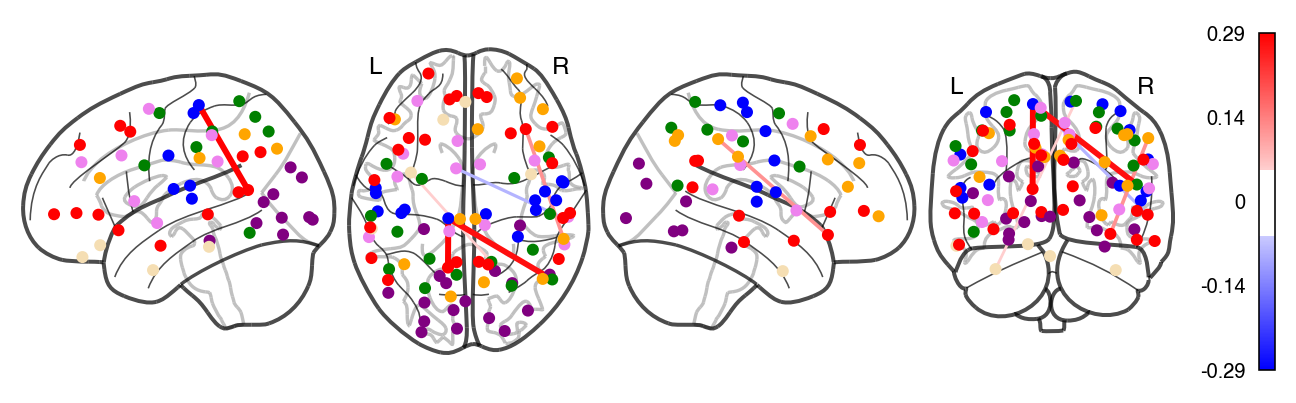

In [27]:
# Schaefer linear regression
coef_df_schaefer, sch_y_hats, sch_y_true, models = linear_models(schaefer_mat.loc[inconsistent_subjects, :], Ys_incon, inconsistency_measure, 'Lasso', 45)
r, pval = print_results(sch_y_true, sch_y_hats, inconsistency_measure, 'Whole-brain Linear')
sch_avg_linear, sch_linear_score = average_coefs(coef_df_schaefer)
print(f'MSE: {sch_linear_score:.3f}')
draw_glassbrain(sch_avg_linear[-5:].reset_index(drop=True))

/Users/elaine/opt/miniconda3/envs/fc_inconsistency/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


MSE: 0.917


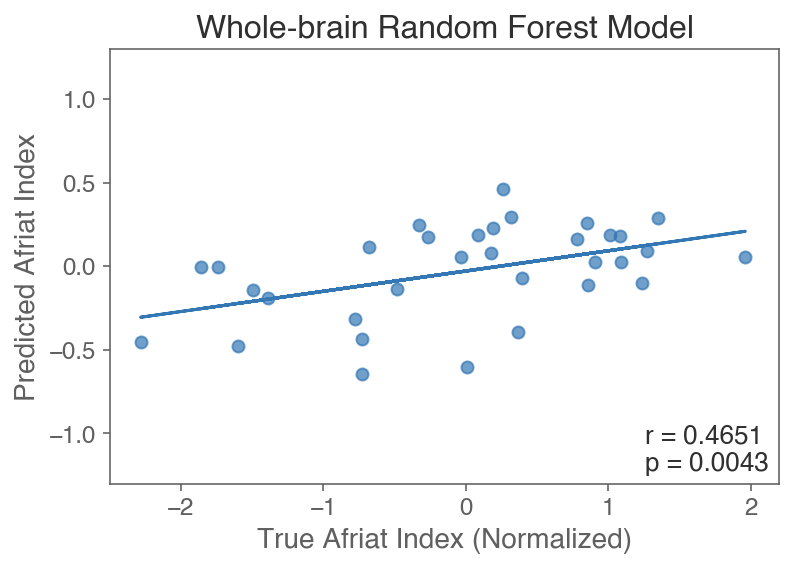

In [29]:
# Schaefer Random Forest with Hyperparameter
rf_coef_df_schaefer, rf_sch_y_hats, rf_sch_y_true, models = random_forest_model(schaefer_mat.loc[inconsistent_subjects, :], Ys_incon, inconsistency_measure, 'RandomForest')
r, pval = print_results(rf_sch_y_true, rf_sch_y_hats, inconsistency_measure, 'Whole-brain Random Forest')
sch_avg_forest, sch_forest_score = average_coefs(rf_coef_df_schaefer)
print(f'MSE: {sch_forest_score:.3f}')

## Save Figures 

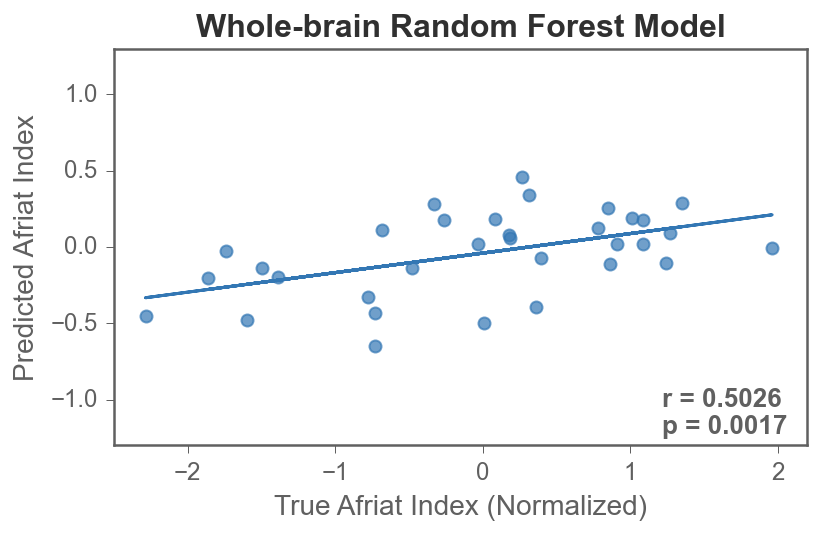

In [636]:
r, pval = print_results(rf_sch_y_true, rf_sch_y_hats, inconsistency_measure, 'Whole-brain Random Forest')
plt.tight_layout()
plt.savefig('whole_brain_rf.svg', dpi = 600)

In [1]:
# motor value RF
r, pval = print_results(mv_y_true, mv_y_hats, inconsistency_measure, 'Value-Motor Random Forest')
plt.tight_layout()
# plt.savefig('mv_rf.svg', dpi = 600)

NameError: name 'print_results' is not defined

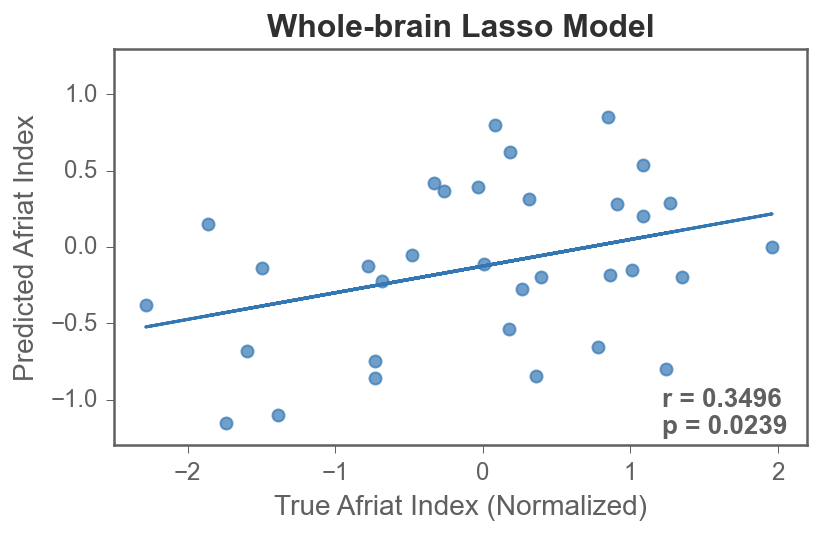

In [547]:
# whole brain lasso
r, pval = print_results(sch_y_true, sch_y_hats, inconsistency_measure, 'Whole-brain Lasso')
plt.tight_layout()
# plt.savefig('whole_brain_lasso.png', dpi = 600)

C:\Users\Asaf\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-3.57299522e-01 -2.19965074e+00 -2.19965115e+00 -3.57299522e-01
 -3.57299522e-01 -3.57299522e-01 -3.57299522e-01 -8.47230080e+56
             nan -2.19965074e+00 -2.19965074e+00 -2.47216879e+26
 -3.57299522e-01 -3.57299522e-01             nan -2.19965115e+00
 -2.19965115e+00             nan -3.57299522e-01 -2.19965115e+00
 -3.57299522e-01 -3.57299522e-01 -2.19965074e+00             nan
 -3.57299522e-01 -2.19965060e+00 -8.47230080e+56 -8.47230080e+56
 -8.47230080e+56             nan             nan -2.47216879e+26
 -2.19965115e+00 -5.10622475e+35             nan -3.63790312e+45
 -2.19965074e+00 -3.57299522e-01 -3.57299522e-01 -3.57299522e-01
 -2.19965115e+00 -5.10622475e+35 -2.19965060e+00 -2.19965115e+00
             nan -3.57299522e-01 -3.63790312e+45 -5.10622475e+35
 -2.19965074e+00 -2.19965074e+00 -3.57299522e-01 -3.57299522e-01
 -3.57299522

NameError: name 'xgxb_sch_score' is not defined

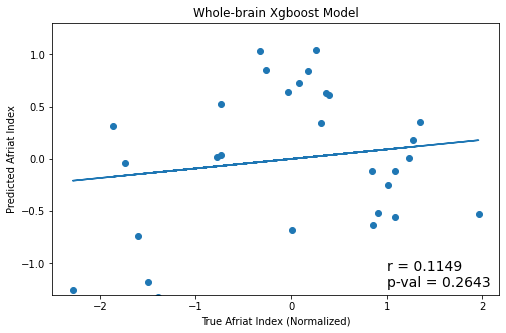

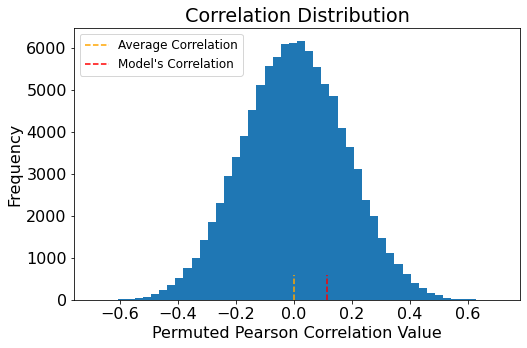

In [49]:
# Schaefer Xgboost with Hyperparameter
xgb_coef_schaefer, xgb_sch_y_hats, xgb_sch_y_true, xgb_models = random_forest_model(schaefer_mat.loc[inconsistent_subjects, :], Ys_incon, inconsistency_measure, 'Xgboost')
r, pval = print_results(xgb_sch_y_true, xgb_sch_y_hats, inconsistency_measure, 'Whole-brain Xgboost')
xgb_sch_avg, xgb_sch_score = average_coefs(xgb_coef_schaefer)
print(f'MSE: {xgb_sch_score:.3f}')
draw_glassbrain(xgb_sch_avg[:5].reset_index(drop=True))

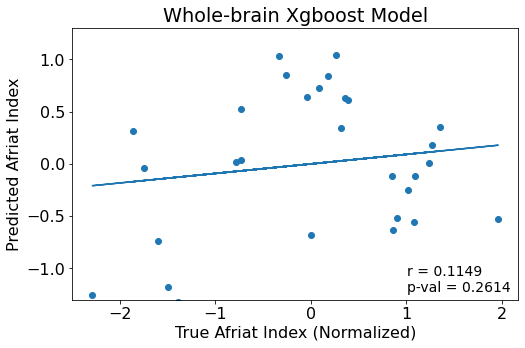

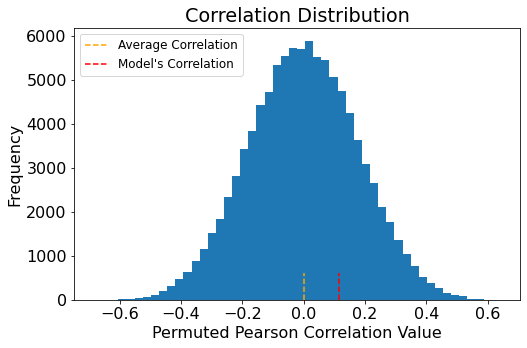

In [51]:
r, pval = print_results(xgb_sch_y_true, xgb_sch_y_hats, inconsistency_measure, 'Whole-brain Xgboost')


## Plot Results on Brain

In [ ]:
import nibabel as nib

In [419]:
sch_labels_path = '/Users/elaine/Downloads/Parcellations/Parcellations/HCP/fslr32k/cifti/Schaefer2018_100Parcels_7Networks_order.dlabel.nii'
labels = nib.load(sch_labels_path)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [43]:
# initiate atlas and labels
with open("../data/Schaefer2018_100Parcels_7Networks_order_info.txt", 'r') as f:
    parcels_text = f.read()
# select only even rows, which contain the labels 
lines = parcels_text.split('\n')[:-1]
lines = lines[::2]
# remove prefix from label: "7Networks_"
parcel_list = [parcel[10:] for parcel in lines]

In [87]:
importance_df = avg_xgb_coefs
# fdata = labels.get_fdata()

for i in range(len(importance_df)):
    # extract each node's name (splitted by "__")
    node1_name = importance_df.loc[i, 'Feature'].split('__')[0]
    node2_name = importance_df.loc[i, 'Feature'].split('__')[1] 
    importance_df.loc[i, 'Node1'] = int(parcel_list.index(node1_name)+1)
    importance_df.loc[i, 'Node2'] = int(parcel_list.index(node2_name)+1)

# create features matrix
node_number = 100
features_matrix = np.zeros([node_number, node_number])
for i in range(len(importance_df)):
    # get the indices of nodes
    node1, node2 = importance_df.iloc[i, 2], importance_df.iloc[i, 3]
    # put the value/beta/importance of nodes in the cifti data
    # fdata[0, np.where((fdata==node1) | (fdata==node2))] = importance_df.iloc[i, 1]

In [89]:
importance_df.to_csv('../data/avg_xgb_coefs_nodes.csv')

## Structural Connectivity

In [ ]:
del get_structural_matrix
# import get_structural_matrix

In [ ]:
import get_structural_matrix
import glob
import re
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [11]:
import importlib
importlib.reload(get_structural_matrix)

<module 'get_structural_matrix' from '/Users/elaine/inconsistency_functional_connectivity/code/get_structural_matrix.py'>

In [72]:
def get_subject_full_cm(path, pass_end, measure, subject):
    subject_file = glob.glob(f'{path}/{subject}*_{measure}_{pass_end}.mat')[0]
    cm = scipy.io.loadmat(subject_file)['CM']
    return cm

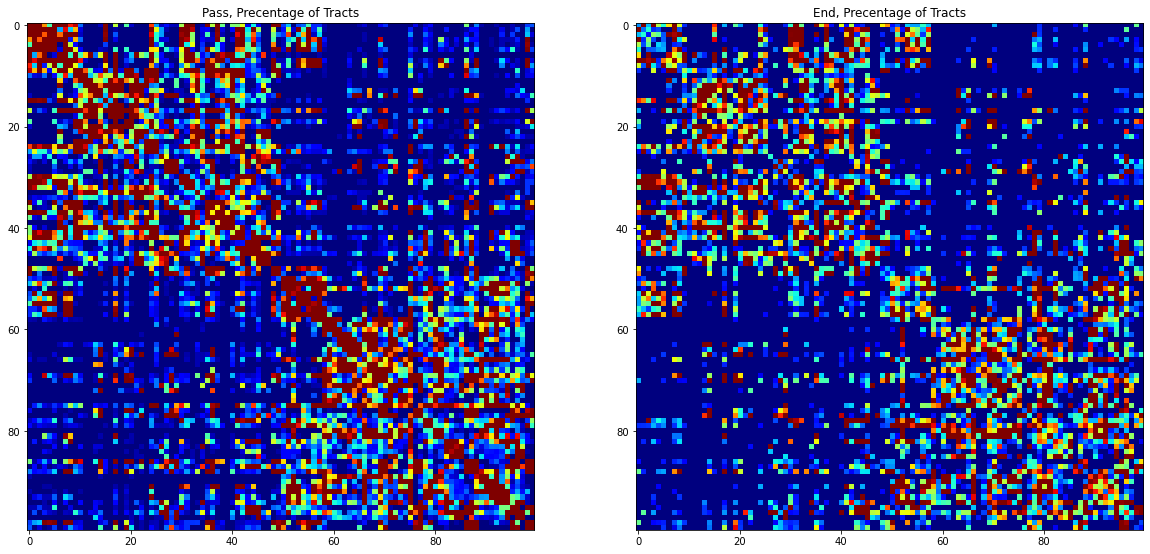

In [27]:
avg_cm = get_structural_matrix.get_avg_cm('/Volumes/homes/Asaf/processed_data/all_DTIs/all_mat/tracts/CMs/', 'PASS', 'percentage_of_tracts')
avg_cm = np.nan_to_num(avg_cm)
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
plt.subplot(1, 2, 1)
plt.imshow(avg_cm, cmap='jet', vmax=0.001)
_ = plt.title('Pass, Precentage of Tracts')

avg_cm = get_structural_matrix.get_avg_cm('/Volumes/homes/Asaf/processed_data/all_DTIs/all_mat/tracts/CMs/', 'END', 'percentage_of_tracts')
avg_cm = np.nan_to_num(avg_cm)
plt.subplot(1, 2, 2)
plt.imshow(avg_cm, cmap='jet', vmax=0.001)
# _ = plt.colorbar()
_ = plt.title('End, Precentage of Tracts')

In [8]:
path = '/Volumes/homes/Asaf/processed_data/all_DTIs/all_mat/tracts/CMs/'
measure = 'percentage_of_tracts'
pass_end = 'END'
paths = glob.glob(f'{path}/*_{measure}_{pass_end}.mat')
avg_cm = np.nanmean([scipy.io.loadmat(path)['CM'] for path in paths], axis=0)
avg_cm = np.nan_to_num(avg_cm)

/var/folders/lv/j0f0x6hs6697tnxm57msbbxh0000gn/T/ipykernel_12396/1797393833.py:5: RuntimeWarning: Mean of empty slice
  avg_cm = np.nanmean([scipy.io.loadmat(path)['CM'] for path in paths], axis=0)


In [48]:
dti_path = '/Volumes/homes/Asaf/processed_data/all_DTIs/all_mat/tracts/CMs/PASS'
fa_df = get_structural_matrix.create_structural_matrix_df(dti_path, 'PASS', 'FA')

In [2]:
dti_path = '/Volumes/homes/Asaf/processed_data/all_DTIs/all_mat/tracts/CMs/PASS'
fa_df = get_structural_matrix.create_structural_matrix_df(dti_path, 'PASS', 'FA')

In [30]:
fa_df = fa_df.set_index(fa_df.index.astype(int))
fa_df = fa_df.dropna(axis=1, how='all')
fa_df = fa_df.fillna(0)

In [72]:
X_fa = fa_df
# choose only subjects that did a resting scan
Ys_fa = behavioral_results.loc[fa_df.index]
# shorten names of variables
Ys_fa = Ys_fa.rename({'AFRIAT Index' : 'Afriat Index', 'VARIAN Index AVG(SSQ)' : 'Varian Index', 'MMI Criterion Avg(SumOfSquares(Wastes))' : 'MMI'}, axis = 1)
all_measures = ['GARP Violations', 'Afriat Index', 'Varian Index', 'Houtman Maks Index', 'MMI']
# remove perfectly-consistent subjects
inconsistent_subjects_fa = Ys_fa.loc[:, 'GARP Violations']!=0
Ys_fa_incon = Ys_fa.loc[inconsistent_subjects_fa, :]
X_fa_incon = X_fa.loc[inconsistent_subjects_fa, :]

/var/folders/lv/j0f0x6hs6697tnxm57msbbxh0000gn/T/ipykernel_39055/1599848282.py:48: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False, axis='both')
/Users/elaine/opt/miniconda3/envs/fc_inconsistency/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


MSE: 1.161


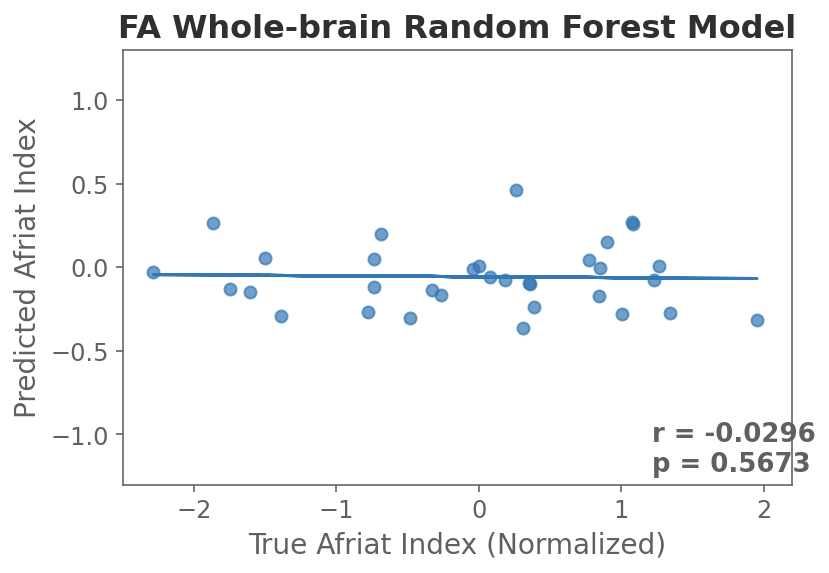

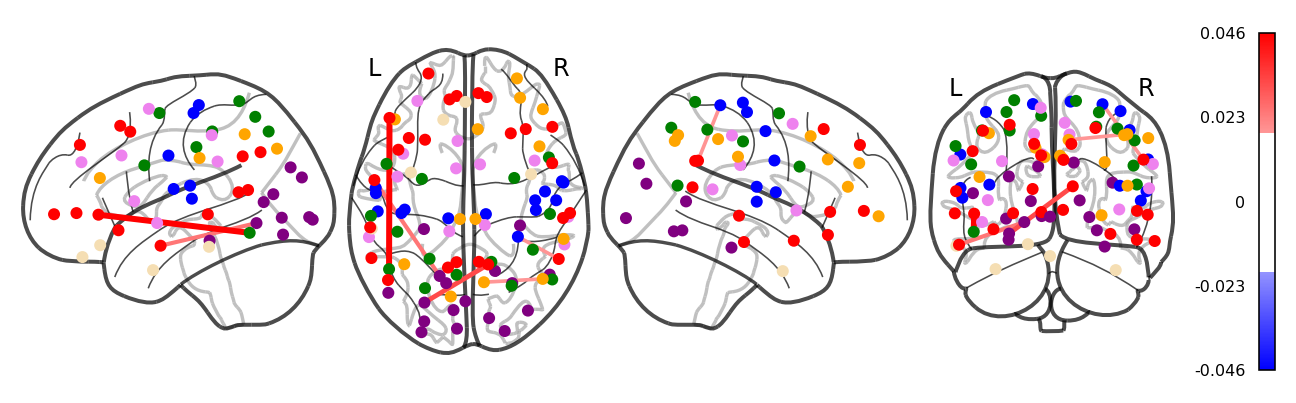

In [73]:
# Schaefer Random Forest with Hyperparameter
rf_fa_coef, rf_fa_y_hats, rf_fa_y_true, fa_models = random_forest_model(fa_df.loc[inconsistent_subjects_fa, :], Ys_fa_incon, inconsistency_measure, 'RandomForest')
r_fa, pval_fa = print_results(rf_fa_y_true, rf_fa_y_hats, inconsistency_measure, 'FA Whole-brain Random Forest')
fa_avg_forest, fa_forest_score = average_coefs(rf_fa_coef)
print(f'MSE: {fa_forest_score:.3f}')
draw_glassbrain(fa_avg_forest[:5].reset_index(drop=True))

In [3]:
dti_path = '/Volumes/homes/Asaf/processed_data/all_DTIs/all_mat/tracts/CMs/PASS'
p_tracts_df = get_structural_matrix.create_structural_matrix_df(dti_path, 'PASS', 'percentage_of_tracts')

In [10]:
mean_pt = p_tracts_df.mean(axis=0)[1:]

In [76]:
p_tracts_df = p_tracts_df.set_index(p_tracts_df.index.astype(int))
p_tracts_df = p_tracts_df.dropna(axis=1, how='all')
p_tracts_df = p_tracts_df.fillna(0)

/var/folders/lv/j0f0x6hs6697tnxm57msbbxh0000gn/T/ipykernel_39055/1599848282.py:48: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False, axis='both')
/Users/elaine/opt/miniconda3/envs/fc_inconsistency/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


MSE: 1.141


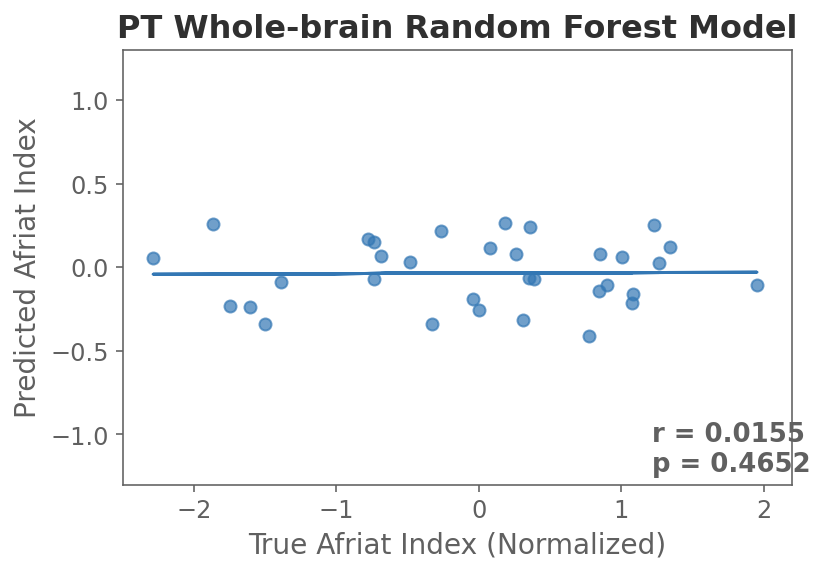

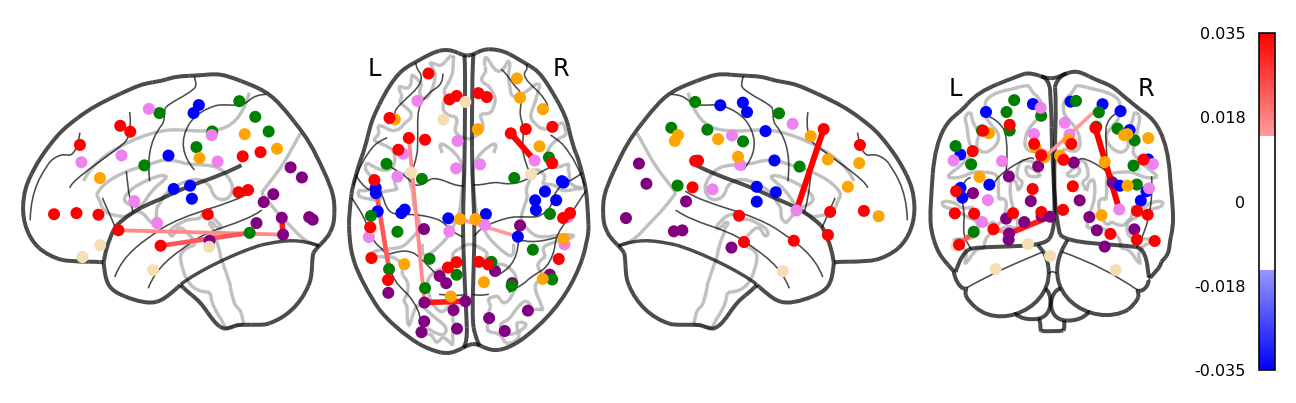

In [77]:
# Schaefer Random Forest with Hyperparameter
rf_pt_coef, rf_pt_y_hats, rf_pt_y_true, pt_models = random_forest_model(p_tracts_df.loc[inconsistent_subjects_fa, :], Ys_fa_incon, inconsistency_measure, 'RandomForest')
r_pt, pval_pt = print_results(rf_pt_y_true, rf_pt_y_hats, inconsistency_measure, 'PT Whole-brain Random Forest')
pt_avg_forest, pt_forest_score = average_coefs(rf_pt_coef)
print(f'MSE: {pt_forest_score:.3f}')
draw_glassbrain(pt_avg_forest[:5].reset_index(drop=True))

In [81]:
dti_path = '/Volumes/homes/Asaf/processed_data/all_DTIs/all_mat/tracts/CMs/PASS'
MD_df = get_structural_matrix.create_structural_matrix_df(dti_path, 'PASS', 'MD')

In [83]:
MD_df = MD_df.set_index(p_tracts_df.index.astype(int))
MD_df = MD_df.dropna(axis=1, how='all')
MD_df = MD_df.fillna(0)

/var/folders/lv/j0f0x6hs6697tnxm57msbbxh0000gn/T/ipykernel_39055/1599848282.py:48: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False, axis='both')
/Users/elaine/opt/miniconda3/envs/fc_inconsistency/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3417: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


MSE: 1.078


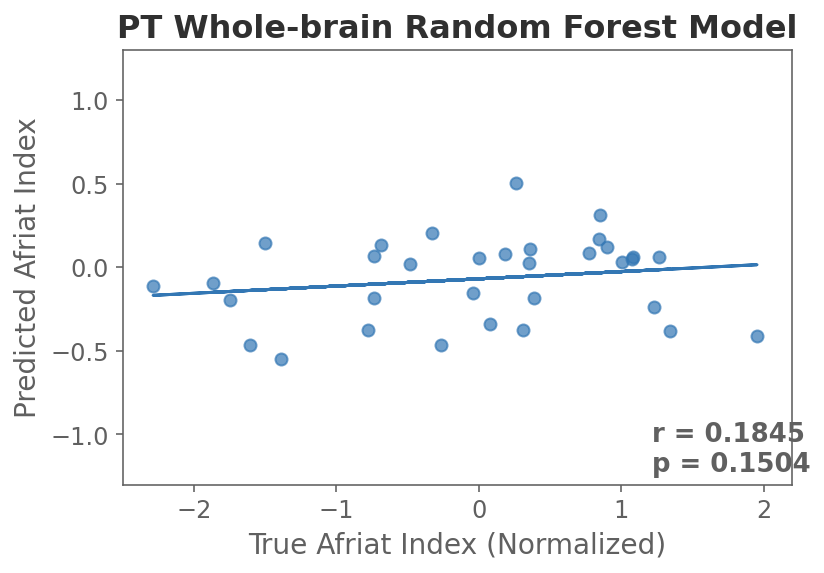

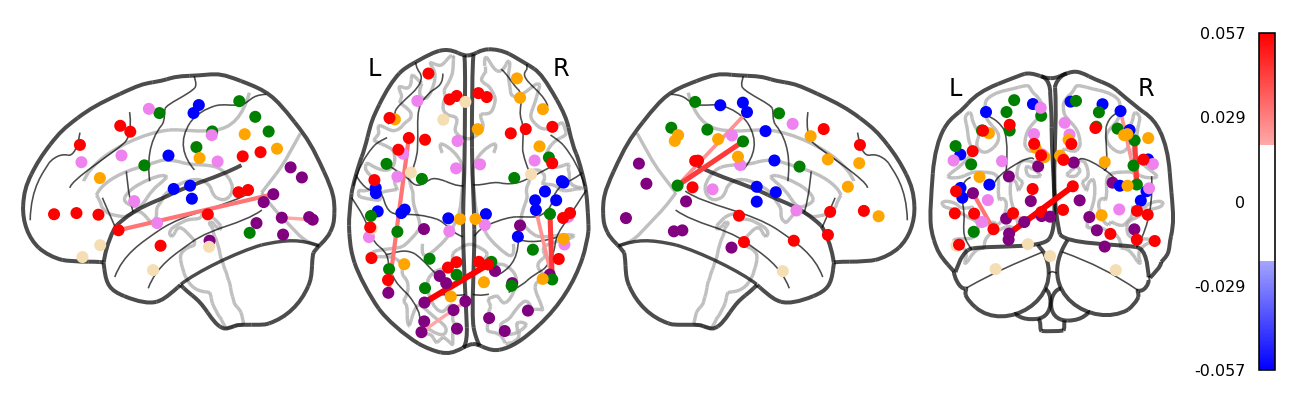

In [84]:
# Schaefer Random Forest with Hyperparameter
rf_md_coef, rf_md_y_hats, rf_md_y_true, md_models = random_forest_model(MD_df.loc[inconsistent_subjects_fa, :], Ys_fa_incon, inconsistency_measure, 'RandomForest')
r_md, pval_md = print_results(rf_md_y_true, rf_md_y_hats, inconsistency_measure, 'PT Whole-brain Random Forest')
md_avg_forest, md_forest_score = average_coefs(rf_md_coef)
print(f'MSE: {md_forest_score:.3f}')
draw_glassbrain(md_avg_forest[:5].reset_index(drop=True))

## SHAP

In [2]:
import shap

In [1085]:
from flask import *

In [1102]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values, features=models[i][1], feature_names=models[i][1].columns)

In [ ]:
def get_shap_html():
    force_plot = shap.force_plot(explainer.expected_value[0], shap_values, features=models[i][1], feature_names=models[i][1].columns)
    shap_html = f"<head>{shap.getjs()}</head><body>{force_plot.html()}</body>"
    return render_template()
    htmls.append(shap_html)

In [1110]:
shap.initjs()
htmls = []
i = 0
shaps = np.empty((len(models), 4950))
for i in range(len(models)):
    explainer = shap.TreeExplainer(models[i][0])
    shap_values = explainer.shap_values(models[i][1])
    shaps[i] = shap_values
    force_plot = shap.force_plot(explainer.expected_value[0], shap_values, features=models[i][1], feature_names=models[i][1].columns)
    shap_html = f"<head>{shap.getjs()}</head><body>{force_plot.html()}</body>"
    htmls.append(shap_html)
#     force_plots.append(shap.force_plot(explainer.expected_value[0], shap_values, features=models[i][1], feature_names=models[i][1].columns))
#     force_plot = shap.plots.force(models[i][1], shap_values[i], matplotlib=False)
#     shap_html = f"<head>{shap.getjs()}</head><body>{force_plot.html()}</body>"
#     render_template(shap_html)


In [1175]:
mean_shaps = np.mean(shaps, 0)
top_shaps = np.where(np.abs(mean_shaps) > 0.003)[0]

In [3]:
exp = shap.TreeExplainer(models[i][0].predict)

NameError: name 'models' is not defined

In [1210]:
sh[:, 'LH_Vis_2__LH_Vis_1']

.values =
array([0.])

.base_values =
array([0.28588209])

.data =
array([-0.29034229])

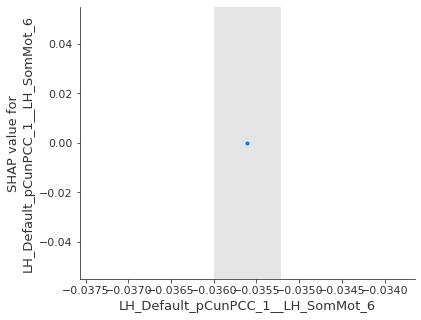

In [1211]:
shap.plots.scatter(sh[:, 'LH_Default_pCunPCC_1__LH_SomMot_6'])

In [1203]:
shap.waterfall_plot(sh.base_values[0], sh.values[0], models[i][1])

AttributeError: 'numpy.float64' object has no attribute 'base_values'

In [1187]:
shap.waterfall_plot(explainer.expected_value[0], explainer(models[i][1]))

AttributeError: 'numpy.float64' object has no attribute 'base_values'

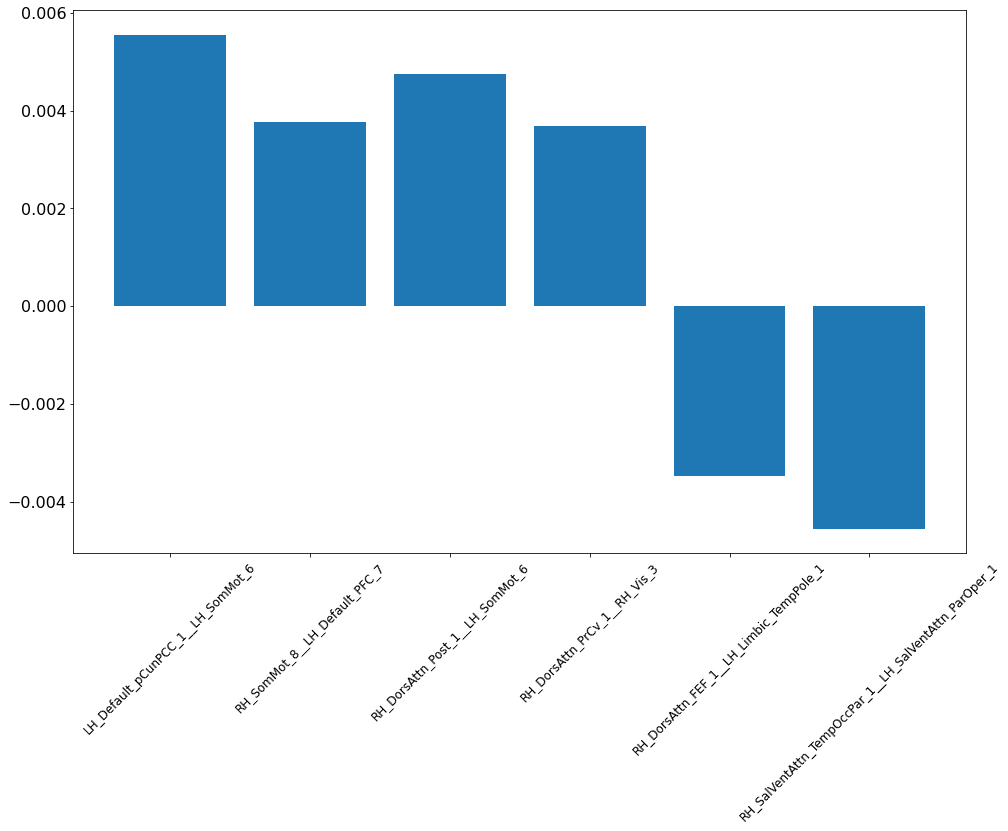

In [1179]:
plt.figure(figsize = (16, 10))
plt.bar(np.arange(len(top_shaps)), mean_shaps[top_shaps])
_ = plt.xticks(np.arange(len(top_shaps)), models[i][1].columns[top_shaps], rotation=45, fontsize=12)

In [1165]:
top_shaps[0]

164

In [1158]:
np.arange(0,len(top_shaps))

array([0])

In [1155]:
sorted(mean_shaps, reverse=True)

[0.005559786007490684,
 0.004751187694605229,
 0.0037688429531999466,
 0.0036819410623998307,
 0.0023481397368529237,
 0.002258046151474775,
 0.0022119725519825382,
 0.001963853577879659,
 0.001960560084704355,
 0.0018145731942499307,
 0.001671439872424629,
 0.001628245871570181,
 0.00136761926935641,
 0.0012356494158793556,
 0.00121207840746242,
 0.0011633105721250417,
 0.001131203870180288,
 0.00109215554830536,
 0.0010645468341014953,
 0.001050475619354615,
 0.0010139662961464561,
 0.0009915386318822004,
 0.0009858068050206535,
 0.0009750050709417568,
 0.0009749100512761358,
 0.0009556026137074281,
 0.0009525723582867414,
 0.0009513809920733752,
 0.0009207193766904926,
 0.0009166030801929044,
 0.0008838637392004322,
 0.0008574085609935157,
 0.0008511167537556888,
 0.000834326144316948,
 0.0008213956661383491,
 0.0008210251374149671,
 0.000814542552357556,
 0.0008096444329736436,
 0.0007864200163195949,
 0.0007817058441900595,
 0.0007759123575154293,
 0.0007668984649303136,
 0.000761

In [1000]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(shap_x)[0]
shap.force_plot(explainer.expected_value[0], shap_values, feature_names=shap_x.columns)

# Classification of Inconsistency

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
import xgboost as xgb
from sklearn import svm

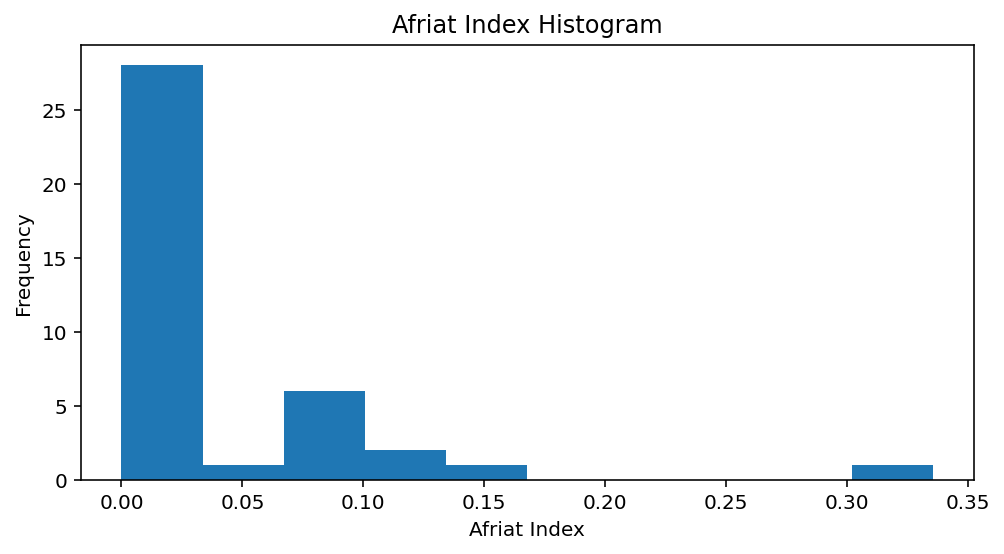

In [18]:
plt.figure(figsize = (8, 4))
plt.hist(Ys[inconsistency_measure])
plt.title(inconsistency_measure + ' Histogram')
plt.ylabel('Frequency')
plt.xlabel(inconsistency_measure)
Ys['Inconsistent'] = Ys[inconsistency_measure] > np.median(Ys[inconsistency_measure])
y_true = Ys['Inconsistent']

In [19]:
def select_features_class(X, y, feature_number):
    f_scores, _ = f_classif(X, y)
    sort_ind = np.argsort(f_scores)
    sorted_features = X.columns[sort_ind]
    selected_features = sorted_features[-1*feature_number:]
    return selected_features

In [20]:
def linear_classifier(X, y, model_type, feature_number):
    '''
    Trains a model: Logistic Regression. 
    Split train/test, selects features and predicts in with a leave-one-out procedure
    
    Parameters
    ----------------------------
            X - pandas DataFrame
                feature matrix
            y - pandas DataFrame
                DataFrame of target vairables
            measure - string
                name of target variable
            model_type - string
                string of model type, either:
                    'Logistic' - regular logistic regression
            feature_number - int
                number of features to select

    Returns
    ----------------------------
            coefs_list - DataFrame list (or single DataFrame for Random Forest model)
                list of DataFrames containing coefficients and MSEs of the models 
            y_hats - float array
                predicted target values
            y_true - float array
                true target values
            models - sklearn regressors list
                list of models used in the leave-one-out procedure
    '''
    
    models = []
    scores = []
    
    # initiate models, based on model_type
    if model_type == 'Logistic':
#         model = LogisticRegressionCV(cv = 3, n_jobs = -1, random_state = 42, max_iter = 50000, penalty = 'elasticnet', 
#                                      solver = 'saga', l1_ratios = np.arange(0.01, 1, 0.02))
        model = LogisticRegressionCV(cv = 2, n_jobs = -1, random_state = 42, max_iter = 50000)

    loo = model_selection.LeaveOneOut()
    i = 1
    y_hats = []
    y_true = []
    coefs_list = []
    for train_ind, test_ind in loo.split(X):
        X_train, X_test = X.iloc[train_ind, :], X.iloc[test_ind, :]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]
        if model_type != 'Xgboost':
            # select top N features with highest correlation with y_train
            selected_features = select_features_class(X_train, y_train, feature_number)

            X_train, X_test = X_train.loc[:, selected_features], X_test.loc[:, selected_features]

        # scaling X by subject
        X_train = (X_train.transpose() - np.mean(X_train, axis=1)) / np.std(X_train, axis=1)
        X_train = X_train.transpose()
        # scaling by subject therefore using X_test mean and SD
        X_test = (X_test.transpose() - np.mean(X_test, axis=1)) / np.std(X_test, axis=1)
        X_test = X_test.transpose()
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        # save the models, scores and predicted values
        models.append(model)
        score = int(y_test != y_pred)
        y_hats.append(y_pred[0])
        y_true.append(y_test.values[0])
        
        features = X_train.columns
        features = features.append(pd.Index(['Score']))
        coef_df = pd.DataFrame(features, columns = ['Feature'])
        coefs = model.coef_
        coef_df['Coefficient'] = np.append(coefs, score)
        # each model might have different sets of features, so we append all DataFrames to a list 
        coefs_list.append(coef_df)
        i += 1
    return coefs_list, y_hats, y_true, models

In [21]:
def build_classifier(X, y, model_type, k_cv=3):
    
    models = []
    scores = []
    
    n_estimators = [int(x) for x in np.linspace(60, 250, 10)]
    n_estimators.append(100)
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 100, 10)]
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2]
    learning_rate = [1, 2, 3]
    param_grid = {'n_estimators' : n_estimators,
                 'max_features' : max_features,
                 'max_depth' : max_depth,
                 'min_samples_split' : min_samples_split,
                 'min_samples_leaf' : min_samples_leaf}
    if model_type == 'Xgboost':
        model = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
        param_grid = {'n_estimators' : n_estimators,
                      'max_depth' : max_depth,
                      'learning_rate' : learning_rate}
        model_cv = GridSearchCV(model, param_grid=param_grid, cv=k_cv) 
    else:
        if model_type == 'RandomForest':
            model = RandomForestClassifier(n_jobs = -1, random_state = 42)
            model_cv = GridSearchCV(model, param_grid=param_grid, n_jobs=-1, cv=k_cv) 

    
    features = X.columns
    features = features.append(pd.Index(['Score']))
    coef_df = pd.DataFrame(features, columns = ['Feature'])

    loo = model_selection.LeaveOneOut()
    i = 1
    y_hats = []
    y_true = []
    coefs = []
    coefs_list = []
    for train_ind, test_ind in loo.split(X):
        X_train, X_test = X.iloc[train_ind, :], X.iloc[test_ind, :]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

        # scaling X by subject
        X_train = (X_train.transpose() - np.mean(X_train, axis=1)) / np.std(X_train, axis=1)
        X_train = X_train.transpose()
        # scaling by subject therefore using X_test mean and SD
        X_test = (X_test.transpose() - np.mean(X_test, axis=1)) / np.std(X_test, axis=1)
        X_test = X_test.transpose()
        
        model_cv.fit(X_train, y_train)
        best_model = model_cv.best_estimator_
        
        y_pred = best_model.predict(X_test)
        models.append(best_model)
        score = int(y_test != y_pred)
        y_hats.append(y_pred[0])
        y_true.append(y_test.values[0])
        if model_type != 'SVM':
            coefs = pd.DataFrame(best_model.feature_importances_)
            coef_df['Coefficient' + str(i)] = np.append(coefs, score)
            coefs_list = coef_df
        i += 1
    return coefs_list, y_hats, y_true, models

In [22]:
def accuracy_permuation(y_pred, y_true):
    '''
    ----
    
    Parameters
    ----------------------------
            y_pred - float array
                predicted target values
            y_true - float array
                true target values
        
    Returns
    ----------------------------
        acc - float

        pval - float

    '''
    permutations = 100000
    acc = metrics.accuracy_score(y_pred, y_true)
    y_pred_permute = y_pred.copy()
    acc_distribution = []

    for i in range(permutations):
        # for each permuation shuffle the predicted values between subjects, and calculate accuracy with the true values 
        random.shuffle(y_pred_permute)
        this_acc = metrics.accuracy_score(y_pred_permute, y_true)
        acc_distribution.append(this_acc)
        
    pval = sum(acc <= acc_distribution) / len(acc_distribution)
    return acc, pval, acc_distribution

### Xgboost

In [22]:
# Xgboost - Motor-value
mv_xgb_coef, mv_xgb_y_hat, mv_xgb_y_true, mv_xgb_models = build_classifier(motor_value_mat.loc[inconsistent_subjects, :], Ys.loc[inconsistent_subjects, 'Inconsistent'], 'Xgboost')
print(f'Xgboost Accuracy: {metrics.accuracy_score(mv_xgb_y_true, mv_xgb_y_hat)}')
mv_acc, mv_acc_pval, mv_acc_dist = accuracy_permuation(mv_xgb_y_hat, mv_xgb_y_true)
print(f'p-val of accuracy: {mv_acc_pval}')

In [ ]:
## TAKES 1 HOURS TO RUN ##
# Xgboost - Schaefer
xgb_coef, xgb_y_hat, xgb_y_true, xgb_models = build_classifier(schaefer_mat.loc[inconsistent_subjects, :], Ys.loc[inconsistent_subjects, 'Inconsistent'], 'Xgboost')
print(f'Xgboost Accuracy: {metrics.accuracy_score(xgb_y_true, xgb_y_hat)}')
avg_xgb_coefs, _ = average_coefs(xgb_coef)
print(f'Top coefficients: {avg_xgb_coefs[:5]}')
acc, acc_pval, acc_dist = accuracy_permuation(xgb_y_hat, xgb_y_true)


### SVM

In [628]:
_, sch_svm_y_hats, sch_svm_y_true, sch_svm_models = build_classifier(schaefer_mat.loc[inconsistent_subjects, :], Ys.loc[inconsistent_subjects, 'Inconsistent'], 'SVM')
print(f'SVM Accuracy: {metrics.accuracy_score(sch_svm_y_true, sch_svm_y_hats)}')
sch_svm_acc, sch_svm_acc_pval, sch_svm_acc_dist = accuracy_permuation(sch_svm_y_hats, sch_svm_y_true)
print(f'p-val of accuracy: {sch_svm_acc_pval}')

SVM Accuracy: 0.6666666666666666
p-val of accuracy: 0.09039


In [609]:
_, mv_svm_y_hats, mv_svm_y_true, mv_svm_models = build_classifier(motor_value_mat.loc[inconsistent_subjects, :], Ys.loc[inconsistent_subjects, 'Inconsistent'], 'SVM')
print(f'SVM Accuracy: {metrics.accuracy_score(mv_svm_y_true, mv_svm_y_hats)}')
mv_svm_acc, mv_svm_acc_pval, mv_svm_acc_dist = accuracy_permuation(mv_svm_y_hats, mv_svm_y_true)
print(f'p-val of accuracy: {mv_svm_acc_pval}')

### Gradient Boosting

In [114]:
# Gradient Boosting classifier - Motor value
gb_class, gb_y_hat, gb_y_true, gb_models = build_classifier(motor_value_mat.loc[inconsistent_subjects, :], Ys.loc[inconsistent_subjects, 'Inconsistent'], 'GradientBoosting')
print(f'Gradient Boosting Accuracy: {metrics.accuracy_score(gb_y_hat, gb_y_true)}')

Gradient Boosting Accuracy: 0.48484848484848486


In [702]:
# Gradient Boosting classifier
gb_class, gb_y_hat, gb_y_true, gb_models = build_classifier(schaefer_mat.loc[inconsistent_subjects, :], Ys.loc[inconsistent_subjects, 'Inconsistent'], 'GradientBoosting')
print(f'Gradient Boosting Accuracy: {metrics.accuracy_score(gb_y_hat, gb_y_true)}')

Gradient Boosting Accuracy: 0.6666666666666666


### Random Forest

In [701]:
# Random Forest classifier
rf_class, rf_y_hat_class, rf_y_true_class, rf_class_models = build_classifier(schaefer_mat.loc[inconsistent_subjects, :], Ys.loc[inconsistent_subjects, 'Inconsistent'], 'RandomForest')
print(f'Random Forest Accuracy: {metrics.accuracy_score(rf_y_hat_class, rf_y_true_class)}')


Random Forest Accuracy: 0.6060606060606061


### Logistic Regression

In [885]:
# Logistic regression 
logi_coef, logi_y_hat, logi_y_True, logi_models = linear_classifier(schaefer_mat.loc[inconsistent_subjects, :], Ys.loc[inconsistent_subjects, 'Inconsistent'], 'Logistic', 45)
print(f'Logistic Regression Accuracy: {metrics.accuracy_score(logi_y_True, logi_y_hat)}')

Logistic Regression Accuracy: 0.5757575757575758


In [587]:
X.shape, y.shape

((10, 50), (50,))

In [588]:
s.fit(X.transpose(), y)

SVC()

In [594]:
s.decision_function(X.transpose())

array([-1.00878573, -0.96597311, -0.9228885 , -0.87954367, -0.83595053,
       -0.79212109, -0.74806749, -0.70380196, -0.65933684, -0.61468456,
       -0.56985764, -0.52486868, -0.47973036, -0.43445542, -0.38905668,
       -0.34354702, -0.29793936, -0.25224667, -0.20648196, -0.16065829,
       -0.11478872, -0.06888635, -0.02296431,  0.02296431,  0.06888635,
        0.11478872,  0.16065829,  0.20648196,  0.25224667,  0.29793936,
        0.34354702,  0.38905668,  0.43445542,  0.47973036,  0.52486868,
        0.56985764,  0.61468456,  0.65933684,  0.70380196,  0.74806749,
        0.79212109,  0.83595053,  0.87954367,  0.9228885 ,  0.96597311,
        1.00878573,  1.0513147 ,  1.09354851,  1.13547576,  1.17708523])

# FDR

In [30]:
ps = [0.00398, 0.0106, 0.0230, 0.0384, 0.1898]
alpha = 0.05
n = len(ps)
rej = np.zeros(n)
for j in range(n):
    fdr = alpha * (j+1) / n
    print(fdr)
    if ps[j] < fdr:
        rej[j] = 1
rej

0.01
0.02
0.030000000000000006
0.04
0.05


array([1., 1., 1., 1., 0.])

### Dino's comments
### To do ###
1. Average matrices for value-motor and Schaefer
2. Check feature correlation matrix and remove highly correlated features
3. Interpretability - What is the relation between the connectivity and the inconsistency? Stronger -> less consistent

#### Done ###
1. Is the fisher transform necessary? - yes, affects results. why?
2. Check more models: Random Forrest, SVM?, Xgboost - RF is the best
3. X axis only negative - make sure the order is saved before and after transformation - the order is saved
4. Change axes values, so they make sense - fixed
5. Squared error - comparing models
6. Add a 45-angle line to compare - dismissed, doesn't look good
7. Draw glass brain 

## Vered's comments
#### Done ####
1. Correlation matrix for Inocnsistency measures
2. Draugowitz - 3 sources for inconsistency
3. Emily Finn - take only top correlations with the y

#### To do? #####
* transform measures to ordinary scale and correlate fc_matrix to ordinary scale
* predict task fmri form rest ??? - Consult with Ido
* Stepwise regression

## Unused - Multiple Regression of Varian ~ features

In [13]:
import statsmodels.api as sm

In [411]:
# Simple regression - Motor-value
measure = all_measures[2]
y = np.log(Ys_incon.loc[:, measure])
X = X_incon
X_ols = sm.add_constant(X)
lm = sm.OLS(y, X_ols)
fitted_model = lm.fit()
print(fitted_model.summary())

                              OLS Regression Results                             
Dep. Variable:     VARIAN Index AVG(SSQ)   R-squared:                       0.980
Model:                               OLS   Adj. R-squared:                  0.837
Method:                    Least Squares   F-statistic:                     6.889
Date:                   Tue, 10 Aug 2021   Prob (F-statistic):             0.0364
Time:                           16:20:21   Log-Likelihood:                -2.2787
No. Observations:                     33   AIC:                             62.56
Df Residuals:                          4   BIC:                             106.0
Df Model:                             28                                         
Covariance Type:               nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const   

In [547]:
# Simple regression - Whole brain
measure = all_measures[2]
top_features = select_features(schaefer_mat.loc[inconsistent_subjects, :], Ys_incon.loc[:, measure], 0.05, 45)
y = np.log(Ys_incon.loc[:, measure])
X = schaefer_mat.loc[inconsistent_subjects, top_features]
lm = linear_model.LassoCV(max_iter = 50000, n_jobs = -1)
lm.fit(X, y)

LassoCV(max_iter=50000, n_jobs=-1)

In [557]:
X['Varian'] = y.values

In [558]:
# write X to csv for Rstudio
X.to_csv('/Users/elaine/Dropbox/LabDropbox/Asaf/python/whole_brain.csv')


                              WLS Regression Results                             
Dep. Variable:     VARIAN Index AVG(SSQ)   R-squared:                       0.974
Model:                               WLS   Adj. R-squared:                  0.582
Method:                    Least Squares   F-statistic:                     2.486
Date:                   Tue, 10 Aug 2021   Prob (F-statistic):              0.328
Time:                           17:20:06   Log-Likelihood:                -6.4227
No. Observations:                     33   AIC:                             74.85
Df Residuals:                          2   BIC:                             121.2
Df Model:                             30                                         
Covariance Type:               nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

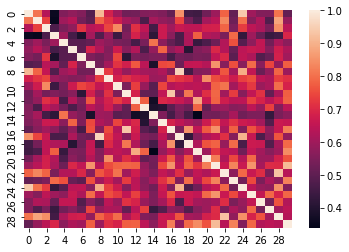

In [520]:
# Simple regression - Whole brain
measure = all_measures[2]
top_features = select_features(schaefer_mat.loc[inconsistent_subjects, :], Ys_incon.loc[:, measure], 0.05, 30)
y = np.log(Ys_incon.loc[:, measure])
X = schaefer_mat.loc[inconsistent_subjects, top_features]
#X = (X - np.mean(X)) / np.std(X)
sns.heatmap(np.corrcoef(X.transpose()))
X_ols = sm.add_constant(X)
lm = sm.OLS(y, X_ols)
fitted_model = lm.fit()
print(fitted_model.summary())

In [401]:
selected_features.get_loc('LH_Default_PFC_6_LH_Limbic_TempPole_2')

1

In [394]:
############## UNFINISHED - DOESN'T WORK
# def remove_multicollinearity(X):

selected_features = X.columns
count = 0
finished = 0
i = 1
while True:
    if i >= len(X.columns)-1:
        break
    else:
        if X.columns[i] not in selected_features:
            i += 1
        else:
            feature_i = X.columns[i]
            print(feature_i)
            data_i = X.loc[:, feature_i]
            j = selected_features.get_loc(feature_i) + 1
            while True:
                if j >= len(selected_features):
                    break
                else:
                    feature_j = selected_features[j]
                    data_j = X.loc[:, feature_j]
                    cor_ij = np.corrcoef(data_i, data_j)[0, 1]
                    if cor_ij > 0.7:
                        selected_features = selected_features.drop(feature_j)
                        count += 1
                    j += 1
            i += 1
#    return selected_features

LH_Default_PFC_6_LH_Limbic_TempPole_2
LH_Default_pCunPCC_2_LH_SomMot_2
RH_Default_Temp_2_RH_SomMot_8
RH_Default_pCunPCC_1_RH_SomMot_6
RH_Limbic_OFC_1_LH_DorsAttn_Post_5
LH_Cont_Cing_1_LH_SomMot_6
RH_SomMot_8_LH_Limbic_OFC_1
RH_Limbic_OFC_1_RH_SalVentAttn_TempOccPar_2
RH_Default_pCunPCC_1_RH_SalVentAttn_Med_2
LH_Default_PFC_3_LH_SomMot_1
RH_DorsAttn_Post_5_LH_Limbic_OFC_1
RH_Limbic_TempPole_1_RH_DorsAttn_Post_5
RH_SalVentAttn_Med_2_LH_Default_PFC_3
